# Example 3.5 and Example 3.6.

### Training of the networks

In [1]:
#from Generate_Date import *
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,normalize
import os
from sklearn.model_selection import train_test_split

# User defined Functions
from Functions.check_convex_order import *
from Functions.marginal_discretization import *
from Functions.generate_samples import *
from Functions.MOT_2dim import *

Execute next line if running on GPU

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Create Data

In [3]:
#generate_and_save_data(payoff,N =100000,nr_support = 20, variance = False, nr_of_variances = 10)

Function for reading data

In [4]:
# # Read Generated Data
def read_data(nr_support = 20, variance = False):
    csv_folder = "csv"

    if variance:
        file_path = csv_folder + '/'+ 'generated_marginals_variance_20pts.csv'
        df2 = pd.read_csv(file_path)
        df2 = df2.dropna()
        y = df2[["Price_min","Price_max"]]
        x = df2.iloc[:,2:(2*nr_support+3)]
    else:
        file_path = csv_folder + '/'+  'generated_marginals.csv'
        df2 = pd.read_csv(file_path)
        df2 = df2.dropna()
        y = df2[["Price_min","Price_max"]]
        x = df2.iloc[:,2:(2*nr_support+2)]
    return x,y

# Fix a payoff Function: |x-y|

In [5]:
def payoff(x,y):
    return abs(y-x)

# Build the Model

In [6]:
def build_model(x,variance = False):
    if variance:
        model = keras.Sequential([
            layers.Dense(512,kernel_regularizer=regularizers.l2(0.00), activation='relu', input_shape=[nr_support*2+1]),
            layers.Dense(512,kernel_regularizer=regularizers.l2(0.00), activation='relu'),
            layers.Dense(512,kernel_regularizer=regularizers.l2(0.00), activation='relu'),
            layers.Dense(512,kernel_regularizer=regularizers.l2(0.00), activation='relu'),
            layers.Dense(2)
          ])
    else:
        model = keras.Sequential([
            layers.Dense(512,kernel_regularizer=regularizers.l2(0.00), activation='relu', input_shape=[nr_support*2]),
            layers.Dense(512,kernel_regularizer=regularizers.l2(0.00), activation='relu'),
            layers.Dense(512,kernel_regularizer=regularizers.l2(0.00), activation='relu'),
            layers.Dense(512,kernel_regularizer=regularizers.l2(0.00), activation='relu'),
            layers.Dense(2)
          ])

    model.compile(loss='mse',
                    optimizer='adam',
                    metrics=['mae', 'mse'])
    scaler = StandardScaler().fit(x)
    return model, scaler

# Train the model (without variance constraints)

read the data

In [7]:
variance = False
nr_support = 20
EPOCHS = 1000
X,y = read_data(nr_support, variance)
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

train the model

In [8]:
model, scaler = build_model(X_train,variance)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
model.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)
history = model.fit(X_train_scaled, y_train,  epochs=EPOCHS,
                    validation_split = 0.2, verbose=1,callbacks = [early_stop])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               20992     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1026      
Total params: 809,986
Trainable params: 809,986
Non-trainable params: 0
_________________________________________________________________
Train on 72000 samples, validate on 18000 samples
Epoch 1/1000
72000/72000 [==============================] - 5s 73u

72000/72000 [==============================] - 4s 62us/sample - loss: 2.2618e-04 - mae: 0.0091 - mse: 2.2618e-04 - val_loss: 6.5462e-05 - val_mae: 0.0064 - val_mse: 6.5462e-05
Epoch 83/1000
72000/72000 [==============================] - 5s 63us/sample - loss: 1.8990e-04 - mae: 0.0083 - mse: 1.8990e-04 - val_loss: 6.1538e-05 - val_mae: 0.0059 - val_mse: 6.1538e-05
Epoch 84/1000
72000/72000 [==============================] - 4s 61us/sample - loss: 1.7754e-04 - mae: 0.0082 - mse: 1.7754e-04 - val_loss: 6.8797e-05 - val_mae: 0.0061 - val_mse: 6.8797e-05
Epoch 85/1000
72000/72000 [==============================] - 4s 57us/sample - loss: 1.7265e-04 - mae: 0.0080 - mse: 1.7265e-04 - val_loss: 7.8710e-05 - val_mae: 0.0068 - val_mse: 7.8710e-05
Epoch 86/1000
72000/72000 [==============================] - 4s 62us/sample - loss: 1.6461e-04 - mae: 0.0078 - mse: 1.6461e-04 - val_loss: 4.7531e-04 - val_mae: 0.0164 - val_mse: 4.7531e-04
Epoch 87/1000
72000/72000 [==============================] - 4s 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


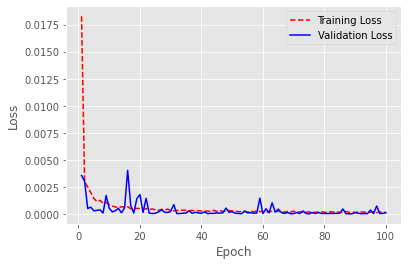

Model Evaluation
10000/10000 - 0s - loss: 1.2760e-04 - mae: 0.0082 - mse: 1.2760e-04
[0.00012760067875497043, 0.008192204, 0.0001276007]


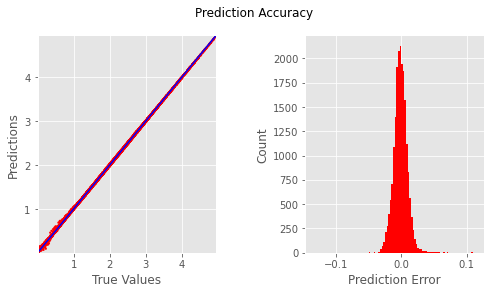

In [9]:
# Plot the loss
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
# Visualize loss history
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('./eps/history_mot.eps', format='eps')
plt.show()

# Plot the errors
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
fig.subplots_adjust(wspace=0.5)
#Along a line
test_predictions = model.predict(X_test_scaled).flatten()
#a = plt.axes(aspect='equal')
axs[0].plot([0,max(test_predictions)],[0,max(test_predictions)],color = "blue")
axs[0].set_xlim(min(test_predictions),max(test_predictions))
axs[0].set_ylim(min(test_predictions),max(test_predictions))
axs[0].scatter(y_test, test_predictions,c='red',s=5, edgecolors='None')
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predictions')

# Histogram
error = np.array(model.predict(X_test_scaled) - y_test).flatten()
axs[1].hist(error, bins = 100,color='red')
axs[1].set_xlabel("Prediction Error")
axs[1].set_ylabel("Count")
fig.suptitle('Prediction Accuracy')
plt.savefig('./eps/accuracy_mot.eps', format='eps')    

# Model Evaluation
print("Model Evaluation")
print(model.evaluate(X_test_scaled, y_test, verbose=2))
model.save("model.h5")

# Train the model with variance constraints

In [10]:
variance = True
nr_support = 20
EPOCHS = 1000
X,y = read_data(nr_support, variance)
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [11]:
model, scaler = build_model(X_train,variance)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
model.summary()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)
history = model.fit(X_train_scaled, y_train,  epochs=EPOCHS,
                    validation_split = 0.2, verbose=1,callbacks = [early_stop])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               21504     
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 1026      
Total params: 810,498
Trainable params: 810,498
Non-trainable params: 0
_________________________________________________________________
Train on 354296 samples, validate on 88574 samples
Epoch 1/1000
354296/354296 [==============================] - 2

354296/354296 [==============================] - 29s 81us/sample - loss: 8.6413e-05 - mae: 0.0056 - mse: 8.6413e-05 - val_loss: 7.2298e-05 - val_mae: 0.0066 - val_mse: 7.2298e-05
Epoch 81/1000
354296/354296 [==============================] - 29s 83us/sample - loss: 7.6319e-05 - mae: 0.0055 - mse: 7.6319e-05 - val_loss: 2.9042e-05 - val_mae: 0.0037 - val_mse: 2.9042e-05
Epoch 82/1000
354296/354296 [==============================] - 31s 87us/sample - loss: 7.3881e-05 - mae: 0.0053 - mse: 7.3881e-05 - val_loss: 1.8648e-05 - val_mae: 0.0031 - val_mse: 1.8648e-05
Epoch 83/1000
354296/354296 [==============================] - 29s 83us/sample - loss: 8.1987e-05 - mae: 0.0054 - mse: 8.1987e-05 - val_loss: 3.9964e-05 - val_mae: 0.0048 - val_mse: 3.9964e-05
Epoch 84/1000
354296/354296 [==============================] - 29s 82us/sample - loss: 6.7566e-05 - mae: 0.0051 - mse: 6.7567e-05 - val_loss: 3.5318e-05 - val_mae: 0.0043 - val_mse: 3.5318e-05
Epoch 85/1000
354296/354296 [====================

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


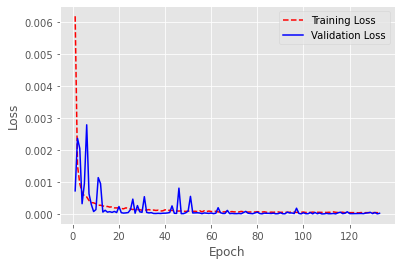

Model Evaluation
49208/49208 - 2s - loss: 3.5553e-05 - mae: 0.0044 - mse: 3.5553e-05
[3.5552675312288363e-05, 0.0044195657, 3.5552686e-05]


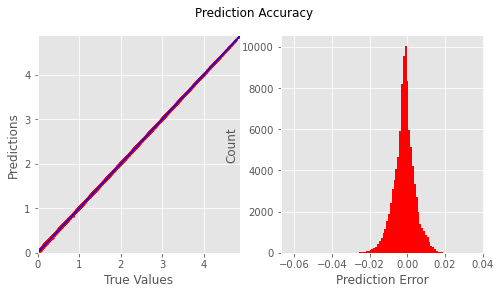

In [12]:
# Plot the loss
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
# Visualize loss history
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('./eps/history_variance.eps', format='eps')
plt.show()



# Plot the errors
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
#Along a line
test_predictions = model.predict(X_test_scaled).flatten()
#a = plt.axes(aspect='equal')
axs[0].plot([0,max(test_predictions)],[0,max(test_predictions)],color = "blue")
axs[0].set_xlim(min(test_predictions),max(test_predictions))
axs[0].set_ylim(min(test_predictions),max(test_predictions))
axs[0].scatter(y_test, test_predictions,c='red',s=5, edgecolors='None')
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predictions')

# Histogram
error = np.array(model.predict(X_test_scaled) - y_test).flatten()
axs[1].hist(error, bins = 100,color="red")
axs[1].set_xlabel("Prediction Error")
axs[1].set_ylabel("Count")
fig.suptitle('Prediction Accuracy')
plt.savefig('./eps/accuracy_variance.eps', format='eps')

# Model Evaluation
print("Model Evaluation")
print(model.evaluate(X_test_scaled, y_test, verbose=2))
model.save("model_variance.h5")